In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
from pixell import curvedsky
from pixell import powspec
from pixell import utils, sharp, enmap
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from pixell import enplot

In [4]:
from PIL import Image
import numpy as np

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

cosmo_img = load_image("cosmo.jpg")

In [5]:
bw_img = np.mean(cosmo_img,axis=2)

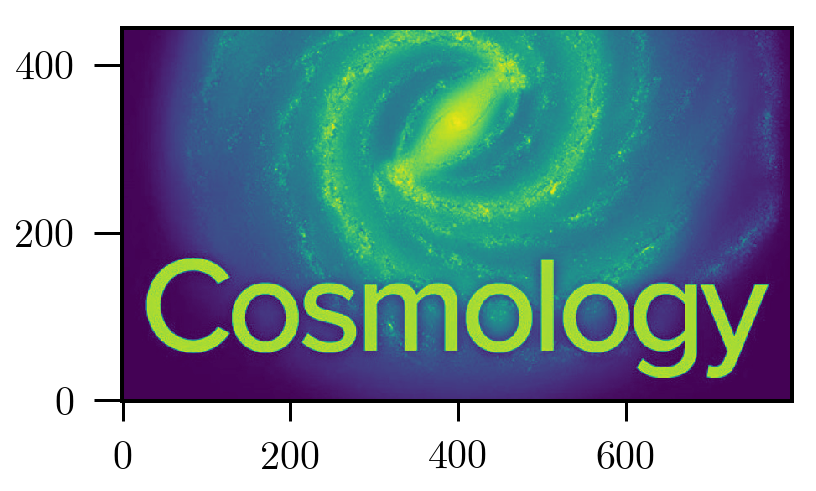

In [6]:
shape=(1,bw_img.shape[0],bw_img.shape[1])
rdeg = np.pi/180
wcs = curvedsky.wcsutils.build( pos=[(0.0),(0.0)], res=5. / 60, system="CAR")
test_map = curvedsky.enmap.empty(shape,  wcs)
test_map[0,::-1,::-1] = bw_img / (255.0)
plt.imshow(test_map[0,:,::-1], vmin=0, vmax=1, origin="lower")

## pixell reconstruction: map2alm to alm2map

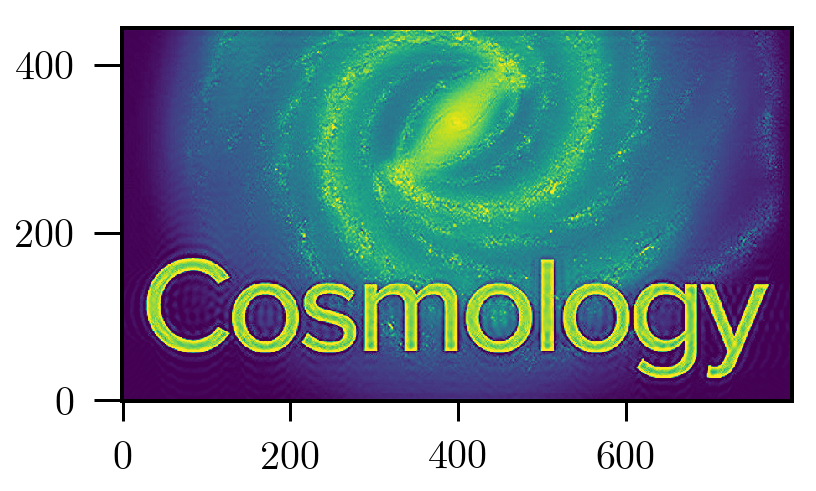

In [16]:
wcs = curvedsky.wcsutils.build( pos=[0.0,0.0], res=5./60, system="CAR")
empty_map = curvedsky.enmap.empty(shape,  wcs)
alm = curvedsky.map2alm(test_map, lmax=4000)
reconstructed = curvedsky.alm2map( alm, empty_map )
plt.imshow(reconstructed[0,:,::-1], vmin=0, vmax=1, origin="lower")

Ok, so this `curvedsky.alm2map` works! Let's paste in the code which accomplishes this, and document exactly what it's doing.

## Debug Infos

In [8]:
alm = curvedsky.map2alm_cyl(test_map, lmax=1000)

In [9]:
# plots = enplot.plot(test_map)
# enplot.write("filename.png",plots)

In [10]:
alm[0,10000]

(-0.0010026886703976732+0.0004281753933650276j)

In [11]:
alm, ainfo = curvedsky.prepare_alm(None, None, 1000, test_map.shape[:-2], test_map.dtype)

In [12]:
tmap, mslices, tslices = curvedsky.make_projectable_map_cyl(test_map)

In [13]:
tmap[:] = 0
for mslice, tslice in zip(mslices, tslices):
    tmap[tslice] = test_map[mslice]
minfo = curvedsky.match_predefined_minfo(tmap, None, None)

In [14]:
# minfo_test = match_predefined_minfo1(tmap, None, None)

In [15]:
7200 * 0.5/60 * np.pi / 180.0

1.0471975511965976

In [16]:
def car_molview(arr, minfo):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111, projection="mollweide")
    plt.title("CAR")

    lon = np.linspace(np.pi,-np.pi,arr.shape[1])
    Lon,Lat = np.meshgrid(lon, np.pi/2 - minfo.theta)

    arr = np.roll(arr, shift=int(arr.shape[1]/2), axis=1)
    im = ax.pcolormesh(Lon,Lat,arr)
    ax.get_xaxis().set_visible(False)
    plt.colorbar(im, fraction=0.02, pad=0.04)

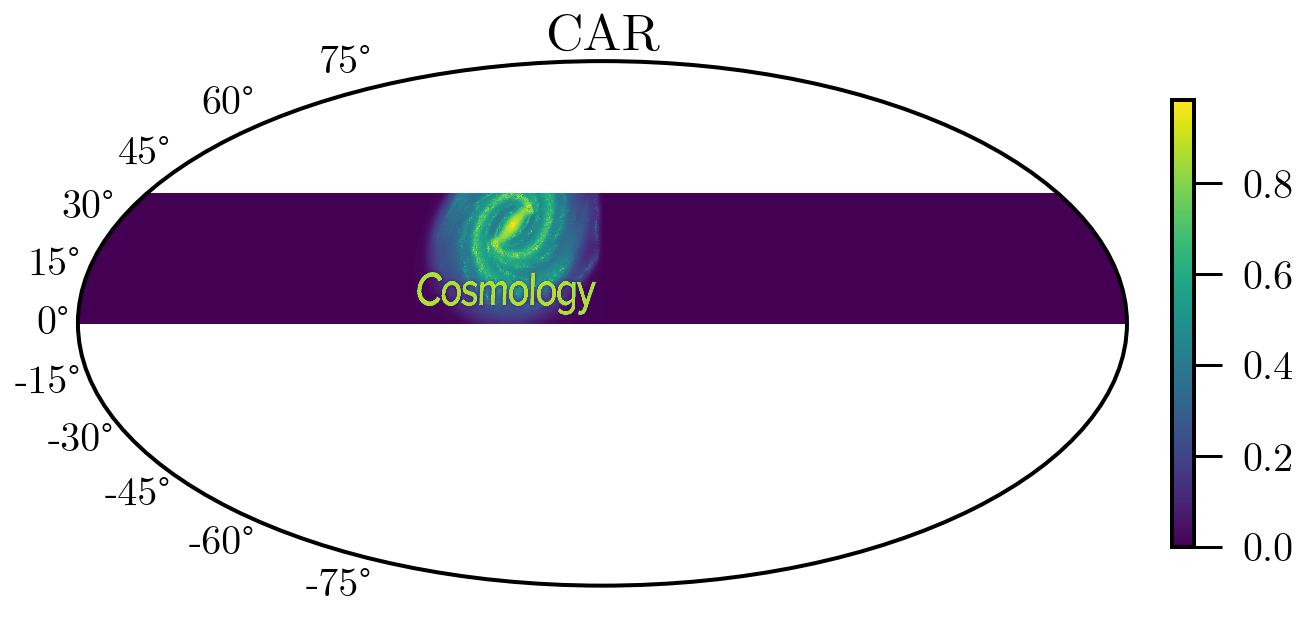

In [17]:
car_molview(tmap[0,:,:], minfo)

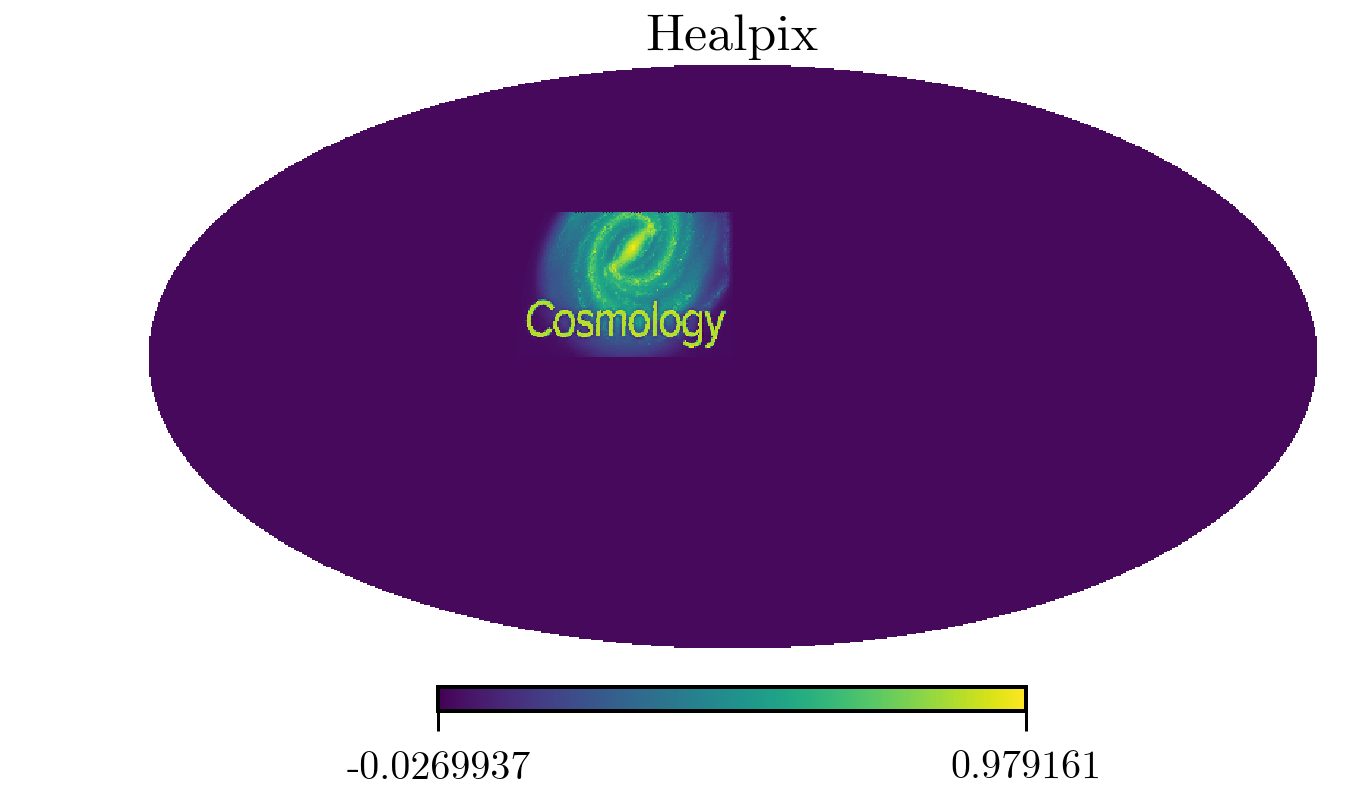

In [23]:
import healpy as hp
heal_map = enmap.to_healpix(tmap[0,:,:], nside=256)
hp.mollview(heal_map,  title="Healpix")

In [24]:
alm = curvedsky.map2alm_raw(tmap, alm, minfo, ainfo, spin=[0])
alm[0,10000]

(-0.0010026886703976732+0.0004281753933650276j)

In [25]:
enmap.write_map("cosmojpg_car.fits", tmap)
hp.write_map("cosmojpg_heal.fits", heal_map, overwrite=True)

In [26]:
hp.write_map("cosmojpg_healmask.fits", heal_map>0.0, overwrite=True)

In [28]:
mask_map = tmap[:]
mask_map[mask_map > 0.0] = 1.0
enmap.write_map("cosmojpg_carmask.fits", mask_map)